In [27]:
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import random

# from scipy.signal import convolve2d
# from scipy.ndimage import convolve

# from perlin_noise import perlin_noise
# from flood_fill import flood_fill

from utils import generate_grid
from utils import plot_trajectory
from utils import spawn_point

import os
import json

In [2]:
plt.rcParams['figure.figsize'] = (16,12)
np.random.seed(1234)

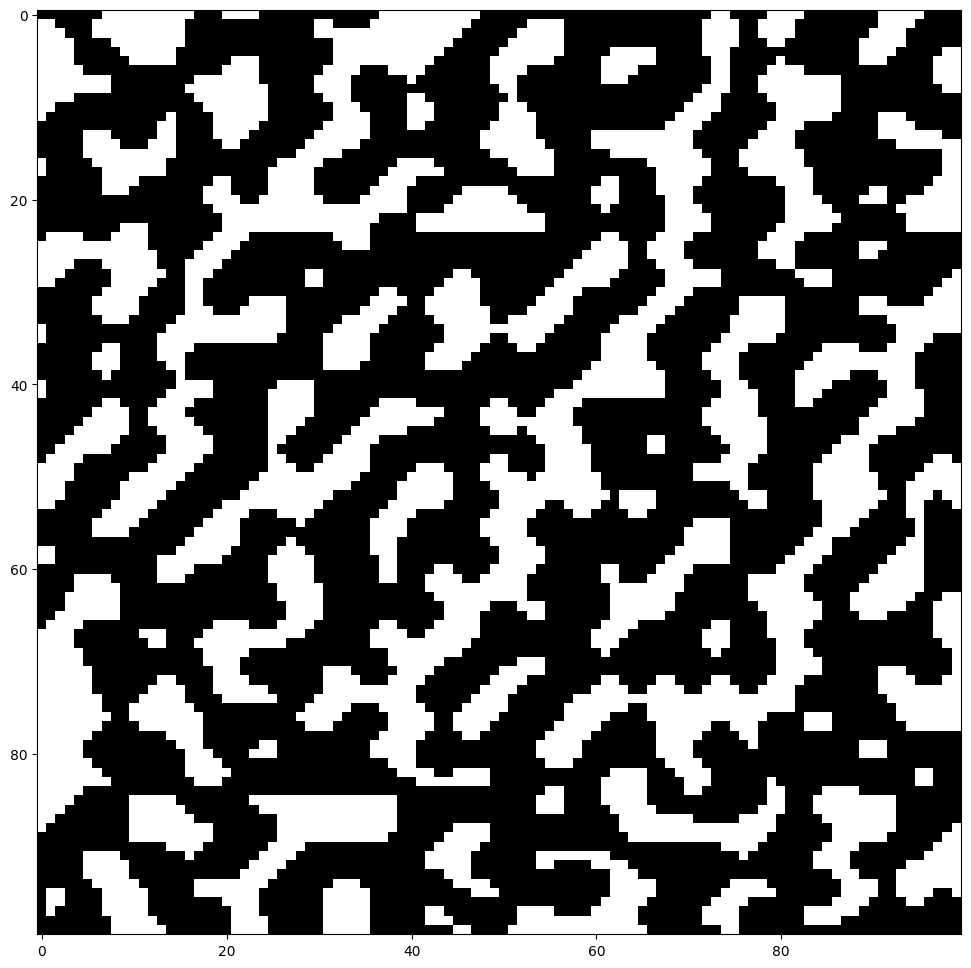

In [3]:
grid = generate_grid(100)
plt.imshow(grid, cmap='grey')
plt.show()

## Movement
 - Randomly move in direction
 - If collision
   - Return to same state
 - Else
   - Keep moving

 % Area covered 0.6390454093470335


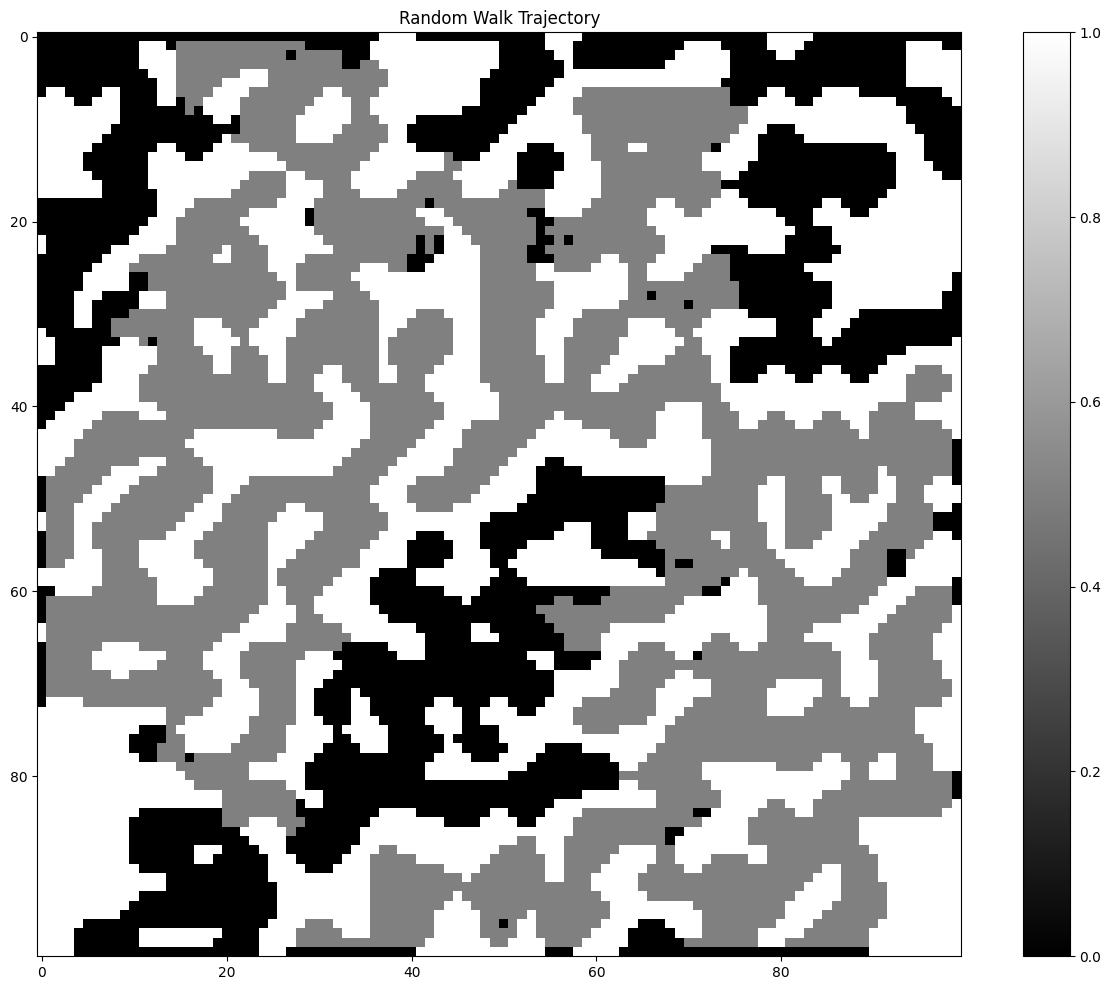

In [4]:
size = 100
grid = generate_grid(size)
height, width = size, size  # Example grid size

# Initialize starting position
current_pos = spawn_point(grid)
x,y = current_pos

# Initialize the trajectory grid and list to track the trajectory
transversed_grid = grid.copy()
trajectory = []
cells_covered = set()

# Number of steps for the random walk
steps = 100000
directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

for i in range(steps):
    # Possible directions for movement (up, down, left, right)

    # Randomly choose a direction
    move = random.choice(directions)

    # Calculate the new position
    new_pos = current_pos + move

    # Ensure the new position is within the grid boundaries
    if 0 < new_pos[0] < height-1 and 0 < new_pos[1] < width-1 and grid[tuple(new_pos)] != 1:
        current_pos = new_pos
        trajectory.append(tuple(current_pos))
        cells_covered.add(tuple(current_pos))

num_cells_covered = len(cells_covered)
empty_cells = np.count_nonzero(grid==0)
area_covered = num_cells_covered/empty_cells
for point in trajectory:
    transversed_grid[point] = 0.5

print(f' % Area covered {area_covered}')
# Display the trajectory as a heatmap
plt.imshow(transversed_grid, cmap='gray')
plt.title("Random Walk Trajectory")
plt.colorbar()
plt.show()

In [5]:
print(f' Number of empty cells {empty_cells}, number of cells covered = {len(cells_covered)}, length of trajectory = {len(trajectory)}')

 Number of empty cells 6034, number of cells covered = 3856, length of trajectory = 87533


## Visibliity
 - Agent can see 5x5 or 3x3 around them
 - Implement by slicing  grid points
 - Initialize unknow global map
 - Update map by slicing information

(100, 100, 3) (100, 100)


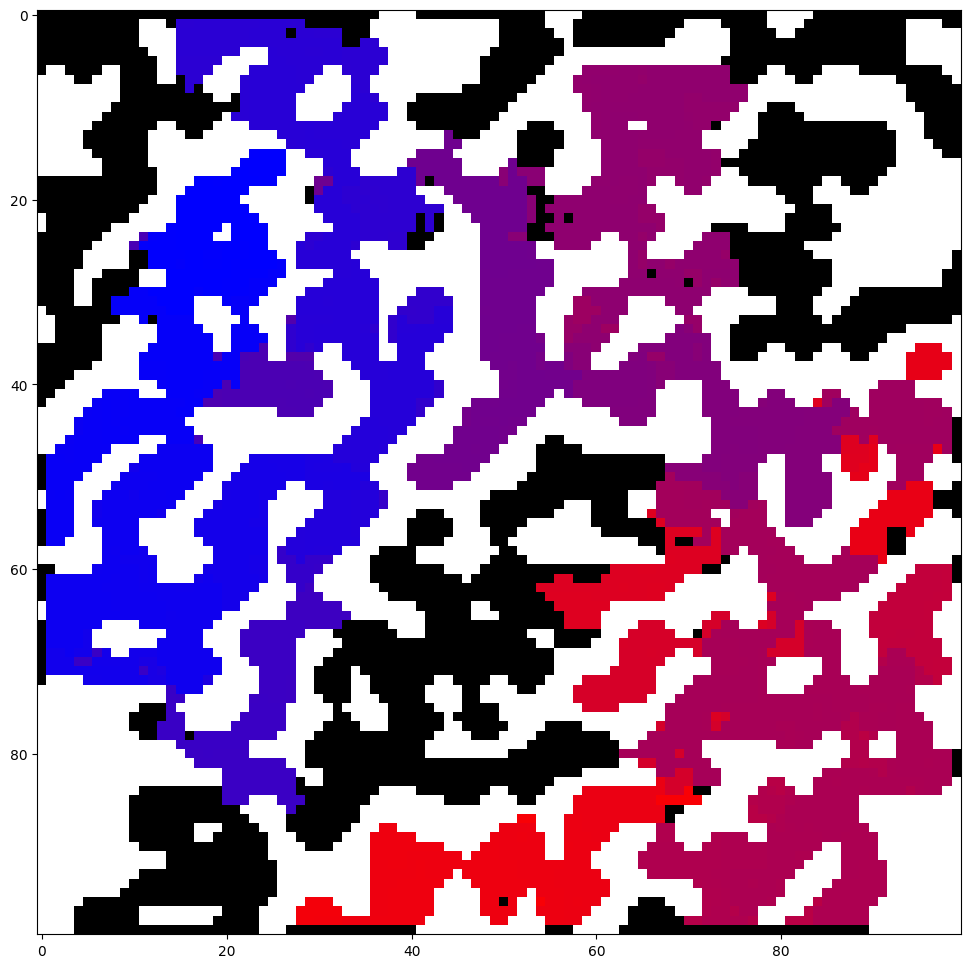

In [6]:
plot_trajectory(grid, trajectory)

In [7]:
# WHEN AT POSITION X,Y
def get_visible(grid, x,y):
    """
    Get the slice of array which is visible to the agent from position x,y
    """
    padding = ((1, 1), (1, 1))
    padded_grid = np.pad(grid, padding, mode='constant', constant_values=-1)
    visible_space = padded_grid[x:x+3, y:y+3]

    return visible_space

## Converting to RL environment
- State = visible patch, current position
- Action = move
- reward = -1
- terminal condition = Whole grid is explored 

In [106]:
class GridEnv():
    def __init__(self, size=100):
        
        self.grid = generate_grid(size)
        self.height, self.width = size, size
        self.actions = {
            "UP" : (0, 1), 
            "DOWN" : (0, -1), 
            "LEFT" : (-1, 0), 
            "RIGHT" : (1, 0),
        }
        self.trajectory = [(0,0)]
        self.action_history = []
        self.agent_start_position = np.array((0,0))
        self.agent_position = self.agent_start_position
        self.visited_cells = set()

    def reset(self):
        self.agent_position = self.agent_start_position
        self.trajectory = []
        self.action_history = []
        done = False
        x,y = self.agent_position
        visible_patch = get_visible(self.grid, x,y)
        state = (self.agent_position, visible_patch)
        return state, done
    
    def step(self, action):
        movement = self.actions[action]
        new_position = self.agent_position + movement
        done = False
        self.action_history.append(action)
        if 0 <= new_position[0] <= self.height-1 and 0 <= new_position[1] <= self.width-1 and self.grid[tuple(new_position)] != 1:
            self.agent_position = new_position
            new_position = tuple(new_position)
            self.trajectory.append(new_position)
            
            if new_position not in self.visited_cells:
                reward = 10
                self.visited_cells.add(new_position)
            else:
                reward = -10
        else:
            done = True
            reward = -100

        x,y = self.agent_position
        visible_patch = get_visible(self.grid, x,y)
        new_state = (self.agent_position, visible_patch)

        return new_state, reward, done

    def sample_action(self):
        return random.choice(list(self.actions.keys()))

    def plot_grid(self):
        plt.imshow(self.grid, cmap='gray')
        plt.show()

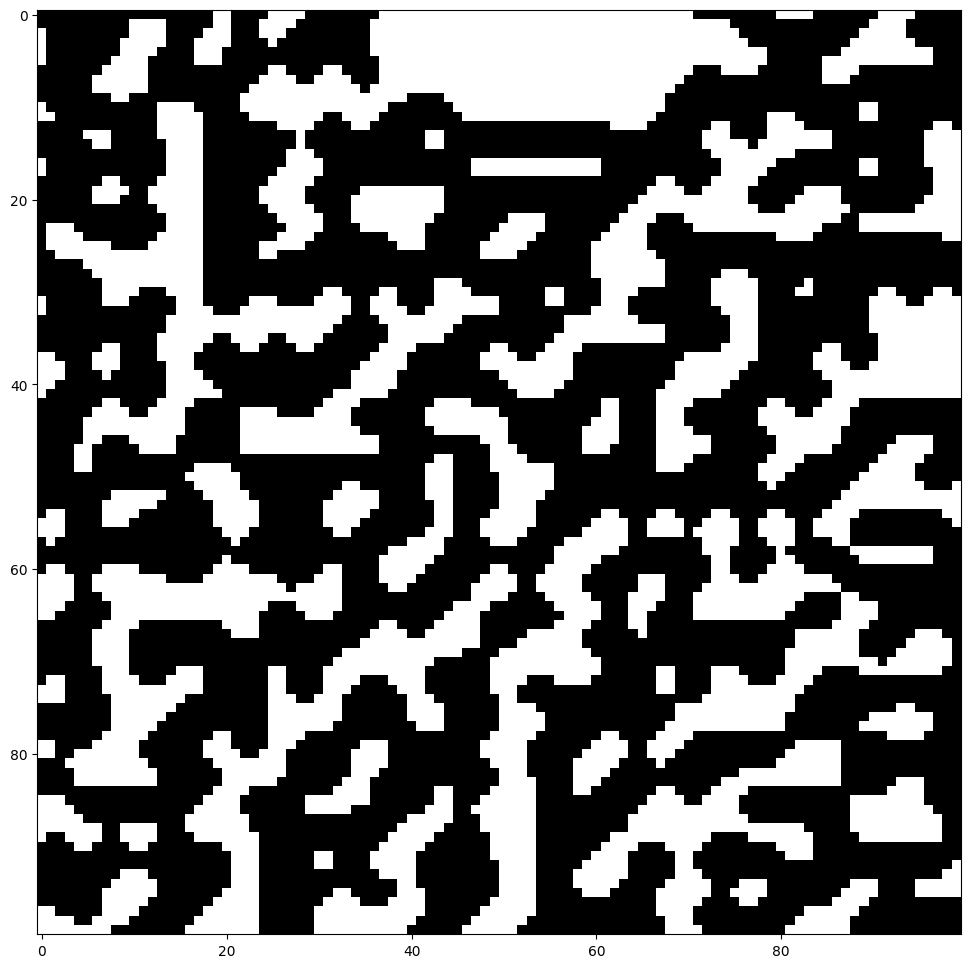

In [107]:
env = GridEnv(size=100)
env.sample_action()
env.plot_grid()

### Agent
- Take random action
- Note trajectory, current position, and visible patch at all times
- Agent can take random action
- Agent needs to add current poision to trajectory
- Agent state -> (4xgrid)
  - 0 for unknown
  - 1 for obstacle
  - 0.5 for explored part,
  - 2 for current position

In [105]:
class Agent():
    def __init__(self, size=100, visible_patch=3):
        self.trajectory = [(0,0)]
        self.position = np.array((0,0))
        self.visible_patch = np.zeros((visible_patch,visible_patch))
        self.grid = np.zeros((size, size))
        self.size = size
    
    def update_state(self, visible_patch, position):
        x,y = position
        visible_patch = (visible_patch + 1) * (0.5)
        for dx in range(-1, 2):  # This will loop through -1, 0, 1
            for dy in range(-1, 2):  # This will loop through -1, 0, 1
                nx, ny = x + dx, y + dy            
                if 0 <= nx < size and 0 <= ny < size:
                    self.grid[nx][ny] = visible_patch[1+dx,1+dy]
        self.trajectory.append(tuple(position))

        # TO ACCOMODATE FOR CURRENT POSITION, CAN ALSO SAVE AS NEXT POSITION
        state_grid = self.grid.copy()
        state_grid[x,y] = 2
        return state_grid

    def show_grid(self):
        plt.imshow(self.grid, cmap='grey')
        plt.show()

### Run agent for n random samples
Run the agent for 100,000 random samples and see how the agent behaves and how much area the agent explores

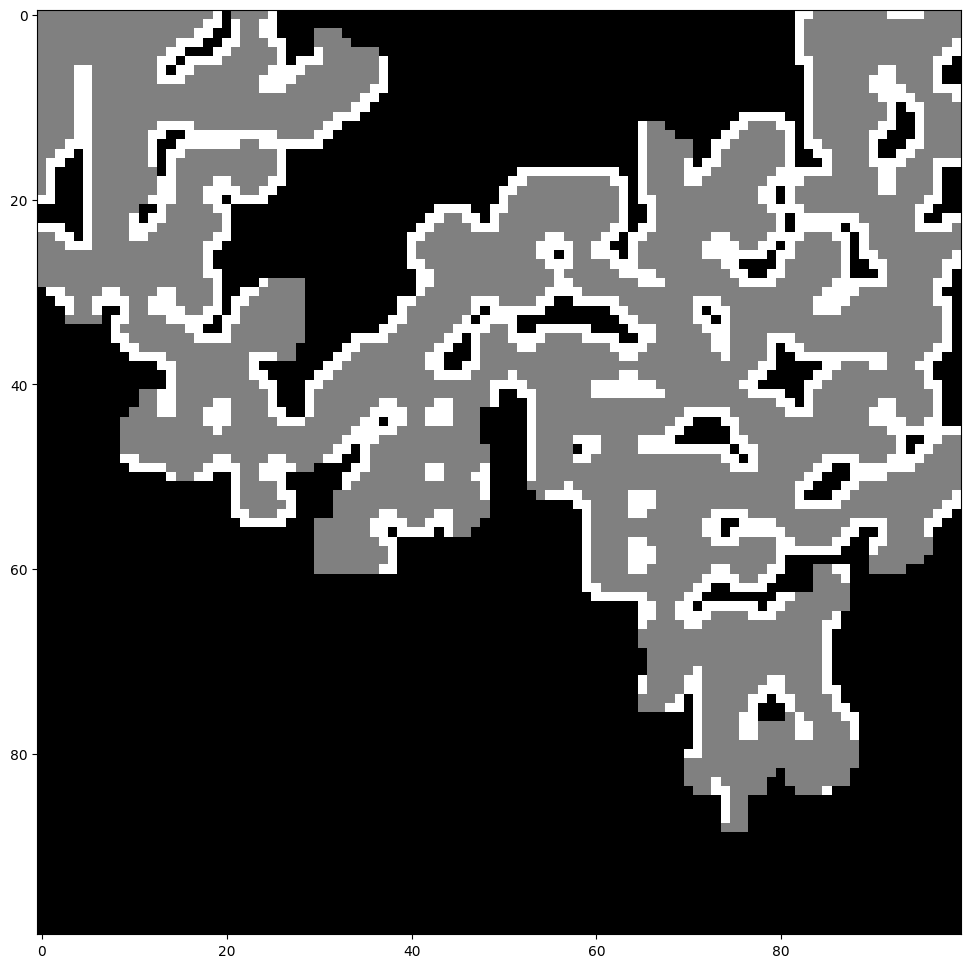

In [72]:
agent = Agent()
env.reset()

for i in range(100_000):
    action = env.sample_action()
    new_state, reward, done = env.step(action)

    new_pos, visible_patch = new_state
    agent.update_state(visible_patch, new_pos)
agent.show_grid()

## Actor Critic Learning
- Policy net
    - 2 2d grids in a tuple
    - 100x100, 3x3 grids
    - Conv2d (x3)-> Linear (x3) -> Softmax 
- Critic Net
    - Conv2d (x3)-> Linear (x3) -> Linear output(Value func)
- Compute Advantage function
    - A =  r + gamma * V(s`) - V(s)
- Evaluate gradient
- Update policy net
    - Select max action, and save log prob of it
    - Multiply each log_prob with Advantage at that step. This is the loss for actor 
- Update critic weights
    - Find error r + gamma * V(s`) - V(s)
    - Find MSE loss -> critic_loss
- Total loss = actor_loss + critic_loss


In [12]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical


In [13]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * 21 * 21, 128)  # After 3 pooling layers (100 -> 12)
        self.fc2 = nn.Linear(128, 4)  # Output 4 classes

        self.flatten = nn.Flatten()
        
        self.patch_fc1 = nn.Linear(9,32)
        self.patch_fc2 = nn.Linear(32,32)
        self.patch_fc3 = nn.Linear(32,4)        
        
    def forward(self, x):
        x1,x2 = x
        
        x1 = self.pool(torch.relu(self.conv1(x1)))
        x1 = self.pool(torch.relu(self.conv2(x1)))
        x1 = torch.relu(self.conv3(x1))
        x1 = self.flatten(x1)
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)
        x1 = F.softmax(x1, dim=1)

        x2 = self.flatten(x2)
        x2 = self.patch_fc1(x2)
        x2 = self.patch_fc2(x2)
        x2 = self.patch_fc3(x2)
        x2 = F.sigmoid(x2)
        x = x1 * x2

        return x

In [14]:
class CriticNet(nn.Module):
    def __init__(self):
        super(CriticNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 21 * 21, 128)
        self.fc2 = nn.Linear(128, 1)

        self.flatten = nn.Flatten()
        
        self.patch_fc1 = nn.Linear(9,32)
        self.patch_fc2 = nn.Linear(32,32)
        self.patch_fc3 = nn.Linear(32,1)
        
    def forward(self, x):
        x1,x2 = x
        
        x1 = self.pool(torch.relu(self.conv1(x1)))
        x1 = self.pool(torch.relu(self.conv2(x1)))
        x1 = torch.relu(self.conv3(x1))
        x1 = self.flatten(x1)
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)

        x2 = self.flatten(x2)
        x2 = self.patch_fc1(x2)
        x2 = self.patch_fc2(x2)
        x2 = self.patch_fc3(x2)
        x = x1 * x2

        return x

In [73]:
class ActorCriticAgent():
    def __init__(self, params):
        pass
        self.actor_net = PolicyNet()
        self.critic_net = CriticNet()
        self.params = params
        self.env = GridEnv()
        self.action_keys = list(self.env.actions.keys())
        self.steps_run = 0
        self.agent_name = self.params['agent_name']
        self.gamma = self.params['gamma']
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.params['num_steps'] = 0
        self.opt = torch.optim.AdamW(list(self.actor_net.parameters()) + list(self.critic_net.parameters()), lr=0.0005)
        self.losses = []
        self.eps_lengths = []
        self.eps_rewards = []

    def get_tensor_state(self, state):
        state_grid, state_patch = state
        state_grid = np.array(state_grid)
        state_grid = torch.tensor(state_grid, dtype=torch.float).to(self.device)
        state_grid = state_grid.unsqueeze(dim=0).unsqueeze(dim=0)
        

        state_patch = np.array(state_patch)
        state_patch = torch.tensor(state_patch, dtype=torch.float).to(self.device)
        state_patch = state_patch.unsqueeze(dim=0)
        state = (state_grid, state_patch)

        return state
    
    def get_action(self, state):

        log_prob = self.actor_net(state)
        probs = torch.softmax(log_prob, dim=-1)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action, log_prob

    def optimize(self, values, log_probs, returns):

        adv = returns - values
        critic_loss = adv.pow(2).mean()
        actor_loss = -(log_probs * adv.detach()).mean()

        total_loss = actor_loss + critic_loss

        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()

        return total_loss.item()

    def reset_env(self):
        state, done = env.reset()
        state_pos, state_patch = state
        state_grid = agent.update_state(state_patch, state_pos)
        state = (state_grid, state_patch)

        return state, done

    def train(self, num_steps=10_000):
        self.params['num_steps'] += num_steps
        state, done = self.reset_env()
        log_probs, values, rewards = [], [], []
        total_reward = 0
        episode_length = 0
        log_freq = self.params['logging_freq']
        for i in range(num_steps):
            # GENERATE 1 EPISODE
            
            # GET ACTION FROM STATE
            state = self.get_tensor_state(state)
            action,  log_prob = self.get_action(state)
            value = self.critic_net(state)
            action = self.action_keys[action.detach().numpy().item()]

            # GET NEXT STATE FROM PERFORMING ACTION
            next_state, reward, done = self.env.step(action)
            next_pos, next_patch = next_state
            next_grid = agent.update_state(next_patch, next_pos)
            next_state = (next_grid, next_patch)

            # STORE INFORMATION IN BUFFER, UPDATE TOTAL REWARD, UPDATE REWARDS LIST
            total_reward += reward

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            
            # IF DONE -> UPDATE AND TRAIN THE NETWORKS
            if done:
                # Compute returns and losses
                returns = []
                G = 0
                for r in reversed(rewards):
                    G = r + self.gamma * G
                    returns.insert(0, G)
        
                values, log_probs = torch.vstack(values), torch.vstack(log_probs)
                returns = torch.from_numpy(np.array(returns))
                loss = self.optimize(values, log_probs, returns)
                
                state, done = self.reset_env()
                log_probs, values, rewards = [], [], []

                self.eps_rewards.append(total_reward)
                self.eps_lengths.append(episode_length+1)
                self.losses.append(loss)

                total_reward = 0
                episode_length = 0

            else:
                
                episode_length += 1
                state = next_state
            
            if (i+1) % log_freq == 0:
                print(f'Step :{i+1}, avg reward = {np.mean(self.eps_rewards[-log_freq:]):.2f}, avg episode length = {np.mean(self.eps_lengths[-log_freq:]):.2f}, avg loss = {np.mean(self.losses[-log_freq:]):.2f}')
        
        # RETURN LOSSES, REWARDS PER EPISODE, AND LENGTH OF EPISODE
        return self.eps_lengths, self.losses, self.eps_rewards


    def save(self):
        agent_name = self.params['agent_name']
        num_steps = self.params['num_steps']
        
        dir_name = os.path.join('saved_models', agent_name, str(num_steps))

        # Create nested directory if it doesn't exist
        os.makedirs(dir_name, exist_ok=True)

        # Save actor model
        actor_path = os.path.join(dir_name, f"{agent_name}_actor.pth")
        torch.save(self.actor_net.state_dict(), actor_path)

        # Save critic model
        critic_path = os.path.join(dir_name, f"{agent_name}_critic.pth")
        torch.save(self.critic_net.state_dict(), critic_path)

        # Save other info
        self.params['eps_rewards'] = self.eps_rewards
        self.params['eps_lengths'] = self.eps_lengths
        self.params['losses'] = self.losses

        params_path = os.path.join(dir_name, f"{agent_name}_params.json")
        with open(params_path, 'w') as f:
            json.dump(self.params, f)


    def load(self, num_steps):
        agent_name = self.params['agent_name']
        dir_name = os.path.join('saved_models', agent_name, str(num_steps))
        params_path = os.path.join(dir_name, f"{agent_name}_params.json")

        # Load params
        with open(params_path, 'r') as f:
            self.params = json.load(f)

        # Load actor model
        actor_path = os.path.join(dir_name, f"{agent_name}_actor.pth")
        self.actor_net.load_state_dict(torch.load(actor_path, weights_only=True))

        # Load critic model
        critic_path = os.path.join(dir_name, f"{agent_name}_critic.pth")
        self.critic_net.load_state_dict(torch.load(critic_path, weights_only=True))

        # Restore tracking variables
        self.eps_rewards = self.params.get('eps_rewards', [])
        self.eps_lengths = self.params.get('eps_lengths', [])
        self.losses = self.params.get('losses', [])

In [74]:
train_parameters = {
    'gamma': 0.99,
    'agent_name': 'actor_critic_v1',
    'logging_freq':1_000,
}
ac_agent = ActorCriticAgent(train_parameters)

eps_lengths, losses, rewards = ac_agent.train(10_000)

Step :1000, avg reward = -91.61, avg episode length = 5.09, avg loss = 1196.33
Step :2000, avg reward = -93.96, avg episode length = 4.91, avg loss = 824.50
Step :3000, avg reward = -97.31, avg episode length = 4.50, avg loss = 506.88
Step :4000, avg reward = -98.85, avg episode length = 4.47, avg loss = 378.07
Step :5000, avg reward = -101.23, avg episode length = 3.95, avg loss = 106.21
Step :6000, avg reward = -102.70, avg episode length = 3.71, avg loss = 0.55
Step :7000, avg reward = -102.55, avg episode length = 3.55, avg loss = 0.13
Step :8000, avg reward = -102.72, avg episode length = 3.71, avg loss = 0.06
Step :9000, avg reward = -102.88, avg episode length = 3.88, avg loss = 0.03
Step :10000, avg reward = -102.95, avg episode length = 3.95, avg loss = 0.01


In [87]:
ac_agent.save()

In [78]:
eps_lengths, losses, rewards = ac_agent.train(50_000)

Step :1000, avg reward = -103.20, avg episode length = 4.20, avg loss = 0.00
Step :2000, avg reward = -103.15, avg episode length = 4.15, avg loss = -0.00
Step :3000, avg reward = -103.09, avg episode length = 4.09, avg loss = -0.00
Step :4000, avg reward = -103.11, avg episode length = 4.11, avg loss = -0.00
Step :5000, avg reward = -103.09, avg episode length = 4.09, avg loss = 0.02
Step :6000, avg reward = -103.13, avg episode length = 4.17, avg loss = 10.15
Step :7000, avg reward = -103.39, avg episode length = 4.46, avg loss = 13.89
Step :8000, avg reward = -103.36, avg episode length = 4.44, avg loss = 14.17
Step :9000, avg reward = -103.38, avg episode length = 4.46, avg loss = 14.18
Step :10000, avg reward = -103.56, avg episode length = 4.60, avg loss = 13.36
Step :11000, avg reward = -103.25, avg episode length = 4.25, avg loss = 0.85
Step :12000, avg reward = -103.15, avg episode length = 4.17, avg loss = 1.39
Step :13000, avg reward = -102.70, avg episode length = 3.72, avg

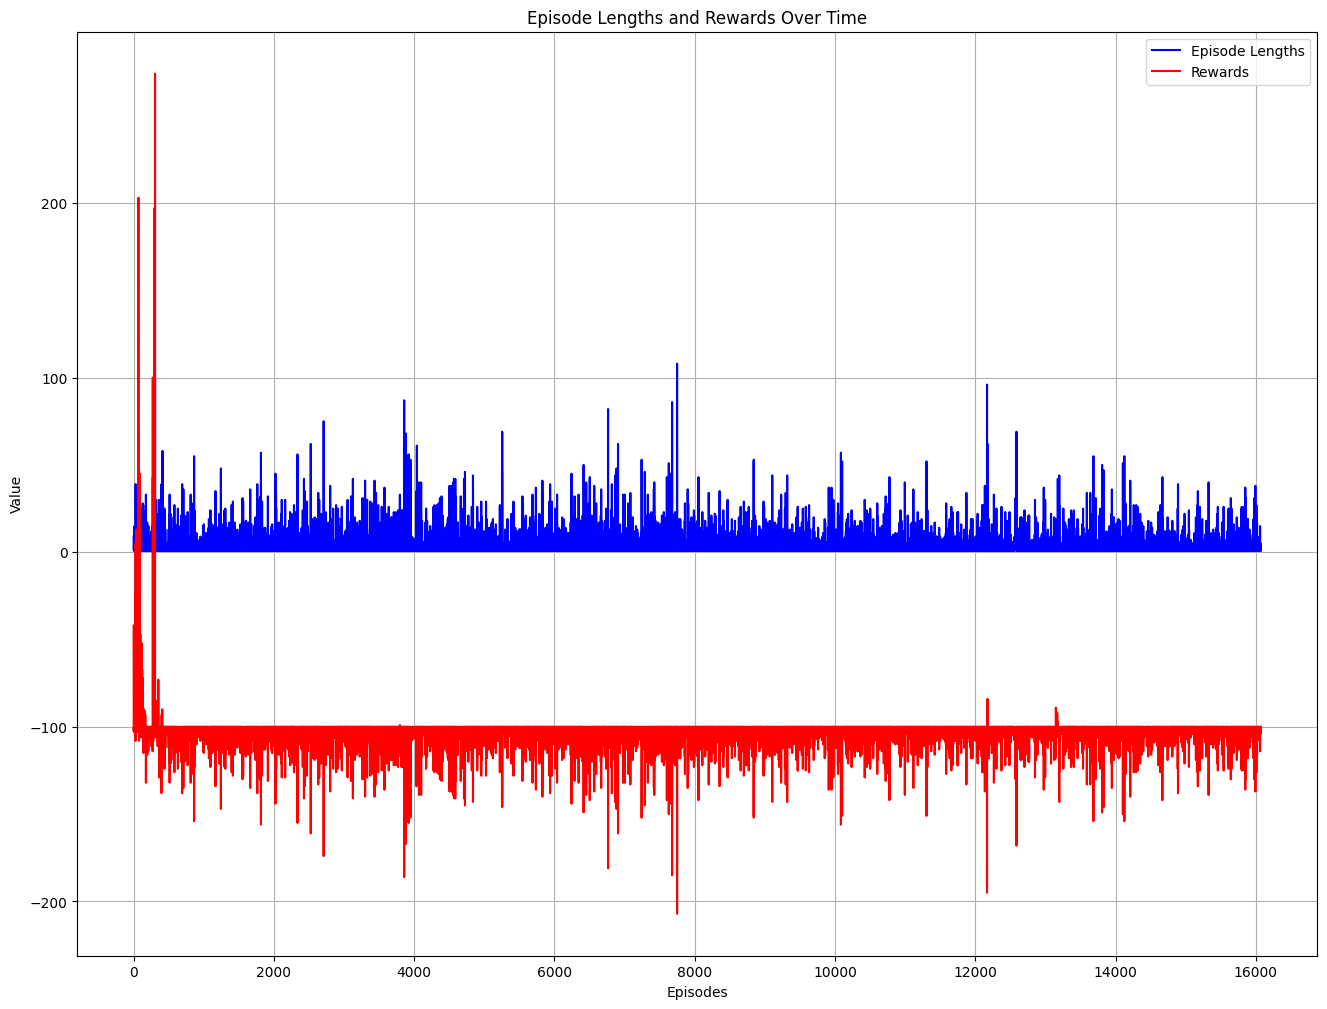

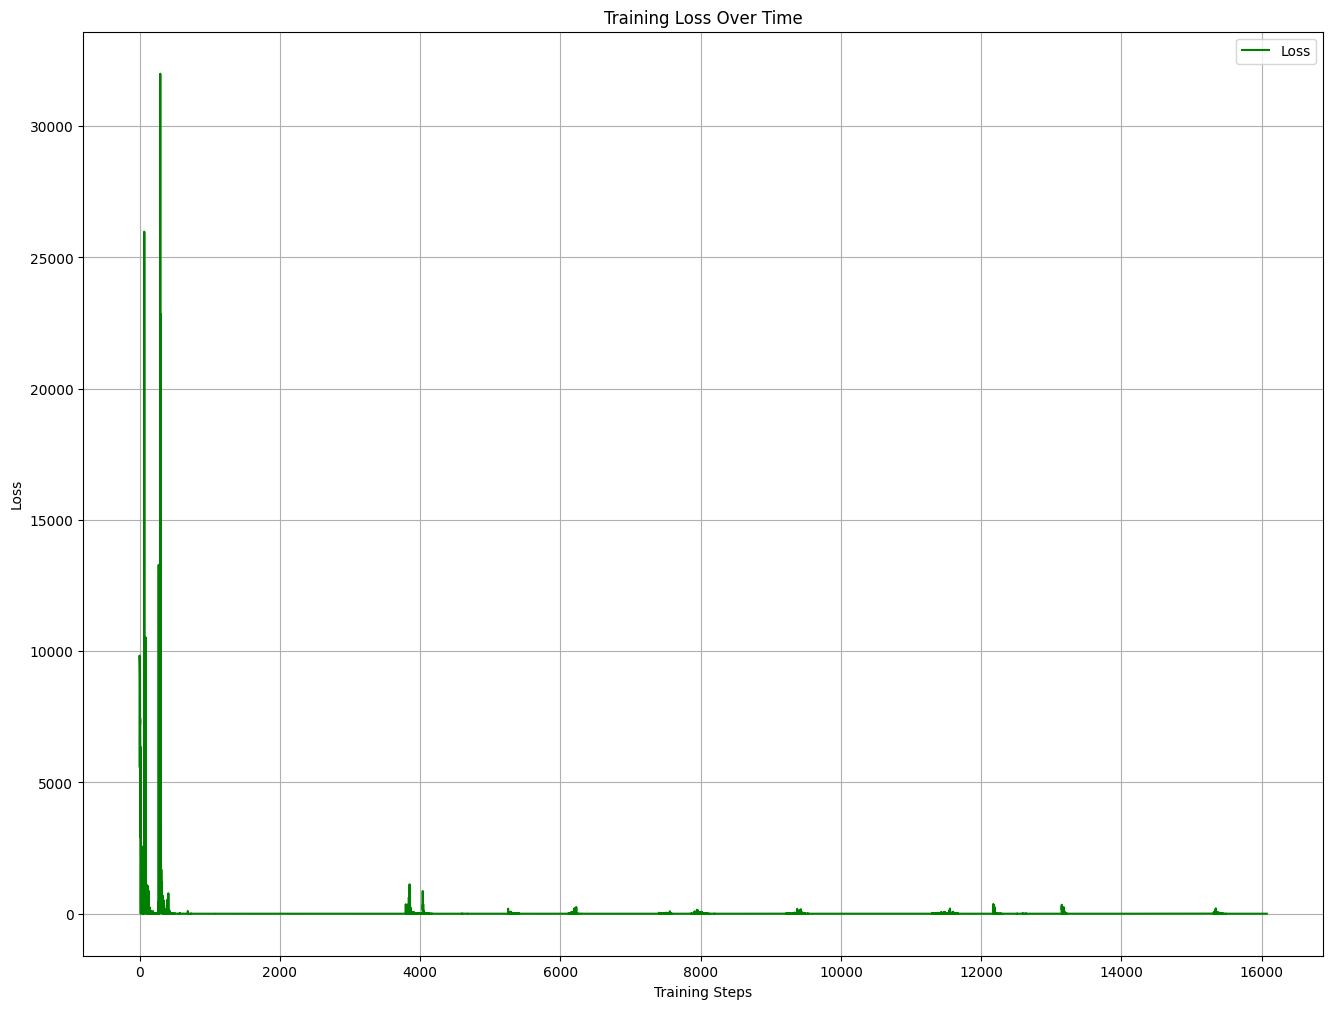

In [83]:
# First plot: Episode lengths and rewards
# plt.figure(figsize=(10, 5))
plt.plot(eps_lengths, c='b', label='Episode Lengths')
plt.plot(rewards, c='r', label='Rewards')
plt.title('Episode Lengths and Rewards Over Time')
plt.xlabel('Episodes')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Second plot: Losses
# plt.figure(figsize=(10, 5))
plt.plot(losses, c='g', label='Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Completed at step 0 with reward -100


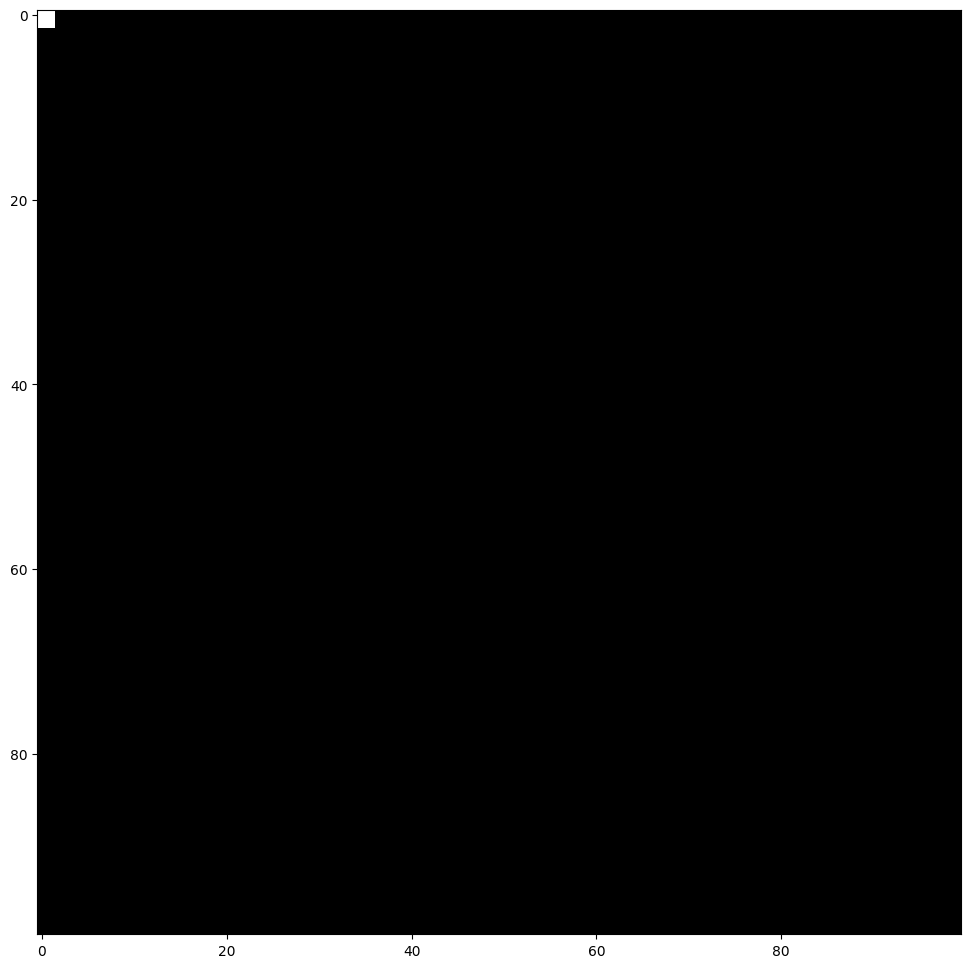

In [111]:
agent = Agent()
state, done = env.reset()
state_grid = np.zeros_like(env.grid)
state_patch = state[1]
state = (state_grid, state_patch)
total_reward = 0
for i in range(100_000):
    
    state = ac_agent.get_tensor_state(state)
    action, _ = ac_agent.get_action(state=state)
    action = ac_agent.action_keys[action.detach().numpy().item()]
    
    next_state, reward, done = env.step(action)
    next_pos, next_patch = next_state
    next_grid = agent.update_state(next_patch, next_pos)
    next_state = (next_grid, next_patch)
    total_reward += reward
    if done:
        print(f'Completed at step {i} with reward {total_reward}')
        break
    state = next_state
agent.show_grid()

In [109]:
env.trajectory,  env.action_history, agent.trajectory

([(0, 1),
  (0, 2),
  (1, 2),
  (1, 1),
  (1, 0),
  (1, 1),
  (1, 2),
  (2, 2),
  (2, 3),
  (1, 3),
  (1, 2),
  (2, 2),
  (2, 3),
  (2, 4),
  (2, 5),
  (2, 4),
  (2, 5),
  (2, 4),
  (2, 3),
  (2, 2),
  (3, 2),
  (3, 3),
  (3, 2),
  (3, 3),
  (3, 4),
  (3, 5),
  (3, 6),
  (3, 7),
  (4, 7),
  (4, 8)],
 ['UP',
  'UP',
  'RIGHT',
  'DOWN',
  'DOWN',
  'UP',
  'UP',
  'RIGHT',
  'UP',
  'LEFT',
  'DOWN',
  'RIGHT',
  'UP',
  'UP',
  'UP',
  'DOWN',
  'UP',
  'DOWN',
  'DOWN',
  'DOWN',
  'RIGHT',
  'UP',
  'DOWN',
  'UP',
  'UP',
  'UP',
  'UP',
  'UP',
  'RIGHT',
  'UP',
  'RIGHT'],
 [(0, 0),
  (0, 1),
  (0, 2),
  (1, 2),
  (1, 1),
  (1, 0),
  (1, 1),
  (1, 2),
  (2, 2),
  (2, 3),
  (1, 3),
  (1, 2),
  (2, 2),
  (2, 3),
  (2, 4),
  (2, 5),
  (2, 4),
  (2, 5),
  (2, 4),
  (2, 3),
  (2, 2),
  (3, 2),
  (3, 3),
  (3, 2),
  (3, 3),
  (3, 4),
  (3, 5),
  (3, 6),
  (3, 7),
  (4, 7),
  (4, 8),
  (4, 8)])

In [110]:
len(env.action_history), len(agent.trajectory)

(31, 32)